In [495]:
import pandas as pd
import math
import numpy as np
import math
from sklearn.cross_validation import train_test_split # to split the dataset for training and testing
from sklearn.preprocessing import normalize # to normalize a matrix
from sklearn.decomposition import PCA
from sklearn import datasets, linear_model, metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor
from scipy import linalg
from sklearn import metrics
import random
import pyswarm
from sklearn.model_selection import learning_curve # to analyze bias and variance of linear regression
import matplotlib.pyplot as plt # for plotting the curves
from sklearn.svm import SVC
from sklearn.svm import SVR

In [496]:
# getting the ratings data in pandas dataframe
ratings = pd.read_csv('../Yahoo_movies_multi-criteria/data_movies.txt', sep='\t',names=['user_id', 'criterion1', 'criterion2', 'criterion3', 'criterion4', 'overall', 'movie_id', 'num'])
print(max(ratings.overall)) # implies that ratings are on a scale of 13
# train, test = sample_split(ratings)
# print(pd.Series.sort_values(ratings.movie_id).unique())

13


In [497]:
print("users: ",ratings.user_id.drop_duplicates().count()) #number of users
print("movies: ",ratings.movie_id.drop_duplicates().count()) #number of movies

users:  6078
movies:  976


In [519]:
num_users = len(ratings.user_id.unique())
print("number of user: ",num_users)

num_items = len(ratings.movie_id.unique())
print("number of items or movies: ",num_items)

print("number of ratings: ",ratings.shape[0])

df_group = ratings.groupby(['user_id'])
avg_rating_per_user = df_group.count().overall.sum()/num_users
avg_user_rating = 0
for index, item in df_group:
    avg_user_rating += item.overall.sum()/item.shape[0]
avg_user_rating /= len(ratings.user_id.unique())
print("Average user rating: ",avg_user_rating)

df_group = ratings.groupby(['movie_id'])
avg_rating_per_item = df_group.count().overall.sum()/num_items
avg_item_rating = 0
for index, item in df_group:
    avg_item_rating += item.overall.sum()/item.shape[0]
avg_item_rating /= len(ratings.movie_id.unique())

print("Average item rating: ",avg_item_rating)

print("Average number of ratings per user: ",avg_rating_per_user)

print("Average number of ratings per item: ",avg_rating_per_item)

print("minimum ratings given by a user: ", min(ratings.groupby(['user_id']).overall.count()))

print("minimum ratings of an item: ", min(ratings.groupby(['movie_id']).overall.count()))

print("maximum ratings given by a user: ", max(ratings.groupby(['user_id']).overall.count()))

print("maximum ratings of an item: ", max(ratings.groupby(['movie_id']).overall.count()))

print("Density ratio = ", (ratings.shape[0]/(num_users*num_items))*100) # only x% of entries in the user-item matrix are filled 

number of user:  6078
number of items or movies:  976
number of ratings:  62156
Average user rating:  9.619394611409506
Average item rating:  9.011235688187424
Average number of ratings per user:  10.226390259953932
Average number of ratings per item:  63.6844262295082
minimum ratings given by a user:  5
minimum ratings of an item:  1
maximum ratings given by a user:  237
maximum ratings of an item:  830
Density ratio =  1.0477858872903618


In [296]:
# function to crop the dataset such that ratings given by any user>=ru
def min_user_ratings_criteria(ratings, ru):
    # remove all users who have rated <= ru movies
    temp = ratings.groupby(['user_id']).overall.count().reset_index()
#     print(temp)
    users_to_be_removed = temp[temp.overall < ru].user_id.unique()
    print(len(users_to_be_removed))
    new_ratings = ratings[~ratings['user_id'].isin(users_to_be_removed)]
    print(len(new_ratings.user_id.unique()))
    return new_ratings
#     print(len(users_to_be_removed))
# min_ratings_criteria(10,1)

In [297]:
# function to crop the dataset such that every item is rated by atleast ri users
def min_item_ratings_criteria(ratings, ri):
    # remove all items with number of ratings <= ri
    temp = ratings.groupby(['movie_id']).overall.count().reset_index()
#     print(temp)
    items_to_be_removed = temp[temp.overall < ri].movie_id.unique()
    print(len(items_to_be_removed))
    new_ratings = ratings[~ratings['movie_id'].isin(items_to_be_removed)]
    print(len(new_ratings.movie_id.unique()))
    return new_ratings
# min_item_ratings_criteria(5)

In [298]:
# split the datasets into smaller datasets, such that every dataset contains 'size' number of users
def split_dataset(ratings, size):
        df_group = ratings.groupby(['user_id'])
#         print(type(df_group))
        
        df_group_list = list()
        # converting the group of dataframes into list of dataframe for random shuffling
        for index, item in df_group:
            df_group_list.append(item)
        # randomly shuffling the list
        random.shuffle(df_group_list)
        no_of_datasets = int(len(df_group)/size);
#         print(no_of_datasets)
        list_datasets = list() # list containing all the small datasets
        temp = pd.DataFrame()
        count=0
        flag=0
        datasets_generated = 0 # datasets that have been generated till now
        for item in df_group_list:
            count+=1
            temp = temp.append(item)
            if count==size and datasets_generated < no_of_datasets-1:
                list_datasets.append(temp)
                print("size = ",temp.shape[0])
#                 print(temp.user_id.unique())
                temp = pd.DataFrame()
                datasets_generated += 1
                count=0
        list_datasets.append(temp) # appending the last dataset
        print("size = ",temp.shape[0])
        return list_datasets
    
# testing above function
# temp = split_dataset(ratings, 1000)
# for item in temp:
#     print(len(item.user_id.unique()))

In [196]:
# Spliting a sample into groups userwise
def sample_split(dataFrame):
    df_group = dataFrame.groupby('user_id')
    train = pd.DataFrame()
    test = pd.DataFrame()
    
    for key, item in df_group:
        train, test = split_train_test(item, train, test)
    
    return train, test

In [197]:
# spliting sample in 70% training data and 30% testing data
def split_train_test(dataFrame, train, test):
    temp_train, temp_test = train_test_split(dataFrame, test_size = 0.3, random_state=1212)# in this our main data is split into train and test
    # the attribute test_size=0.3 splits the data into 70% and 30% ratio. train=70% and test=30%
    train = train.append(temp_train)
    test = test.append(temp_test)
    
    return train, test

In [377]:
# remove movies with <5 ratings
rating_dash = ratings
rating_dash = min_item_ratings_criteria(ratings, 5)
# remove users who have rated <10 items
# rating_dash = min_user_ratings_criteria(rating_dash, 20)
# print(len(rating_dash.movie_id.unique()))
# list conatining all the datasets
list_datasets = split_dataset(rating_dash,500)
print(rating_dash.shape)

69
907
size =  4849
size =  5079
size =  5105
size =  5219
size =  4789
size =  5007
size =  5214
size =  5760
size =  5242
size =  5044
size =  4462
size =  6187
(61957, 8)


In [378]:
# splitting into train and test data
train = list()
test = list()
num_of_datasets = len(list_datasets)
print(num_of_datasets)
for i in range(num_of_datasets):
    print(i)
    t1, t2 = sample_split(list_datasets[i])
    train.append(t1)
    test.append(t2)

12
0
1
2
3
4
5
6
7
8
9
10
11


# Multi-criteria user-user collaborative filtering

In [201]:
# function to find similarity between two users based on Manhattan distance
def manhattan_similarity(df, user1, user2):
    s = pd.merge(df[df['user_id']==user1], df[df['user_id']==user2], how="inner", on="movie_id")
#     print(s)
    sum1 = 0
    similarity=0
    for index, row in s.iterrows():
        sum1 += abs(row.criterion1_x - row.criterion1_y) + \
                abs(row.criterion2_x - row.criterion2_y) + \
                abs(row.criterion3_x - row.criterion3_y) + \
                abs(row.criterion4_x - row.criterion4_y) + \
                abs(row.overall_x - row.overall_y)
        distance = sum1/s.shape[0]
        similarity = 1/(1+distance)
    return similarity
        
# manhattan_similarity(train, 1, 3)

In [202]:
# function to find simialrity between two users based on Euclidean distance
def euclidean_similarity(df, user1, user2):
    s = pd.merge(df[df['user_id']==user1], df[df['user_id']==user2], how="inner", on="movie_id")
#     print(s)
    sum1 = 0
    similarity=0
    for index, row in s.iterrows():
        sum1 += math.sqrt((row.criterion1_x - row.criterion1_y)**2 + \
                (row.criterion2_x - row.criterion2_y)**2 + \
                (row.criterion3_x - row.criterion3_y)**2 + \
                (row.criterion4_x - row.criterion4_y)**2) + \
                (row.overall_x - row.overall_y)**2
        distance = sum1/s.shape[0]
        similarity = 1/(1+distance)
    return similarity
# euclidean_similarity(train, 1, 3)

In [203]:
# function to find simialrity between two users based on Chebyshev distance
def chebyshev_similarity(df, user1, user2):
    s = pd.merge(df[df['user_id']==user1], df[df['user_id']==user2], how="inner", on="movie_id")
#     print(s)
    sum1 = 0
    similarity=0
    for index, row in s.iterrows():
        sum1 += max(abs(row.criterion1_x - row.criterion1_y), \
                abs(row.criterion2_x - row.criterion2_y), \
                abs(row.criterion3_x - row.criterion3_y), \
                abs(row.criterion4_x - row.criterion4_y), \
                abs(row.overall_x - row.overall_y))
        distance = sum1/s.shape[0]
        similarity = 1/(1+distance)
    return similarity
        
# chebyshev_similarity(train, 1, 3)

In [233]:
# function to return a list containing the (similarity of given user with all other users, rating given by the other user)
# list is sorted by similarity in descending order
def similarity_rating(df, user, item, similarity):
    neighbours_data_list = list()
    for v in df.user_id.unique():
        if(v==user): # not including the user itself
            continue
        temp = df[df['user_id']==v]
        temp = temp[temp['movie_id']==item]
        if(temp.empty): # user 'v' has not rated the item
            continue
        else:
            rate = temp.iloc[0].overall
        sim = similarity(df, user, v) # find appropriate similarity measure between the two users
        neighbours_data_list.append((sim, rate))
        
    # sort the neighbours_data_list in descending order based on rate
    neighbours_data_list.sort(reverse=True)
    return neighbours_data_list

In [452]:
# function to predict the rating given by user to item
# neighbours = -1 implies that consider similarity with all possible users
# neighbours_data_list -> list containing the (similarity of given user with all other users, rating given by the other user)
# predict(train[0], row.user_id, row.movie_id,euclidean_similarity, 15)
def predict(df, user, item, similarity, neighbours=-1): # df is the train dataset
    print("predicting...")
    neighbours_data_list = list()
    predicted_rating_list = list()
    for v in df.user_id.unique():
        if(v==user): # not including the user itself
            continue
        temp = df[df['user_id']==v]
        temp = temp[temp['movie_id']==item]
        if(temp.empty): # user 'v' has not rated the item
            continue
        else:
            rate = temp.iloc[0].overall
        sim = similarity(df, user, v) # find appropriate similarity measure between the two users
        neighbours_data_list.append((sim, rate))
        
    # sort the neighbours_data_list in descending order based on rate
    neighbours_data_list.sort(reverse=True)
    
    # crop the list according to the number of neighbours
#         print("neigh = ",neighbours)
    print("input_neigh = ", neighbours)
    if(neighbours!=-1):
        length = len(neighbours_data_list)
        print("neigh = ",length)
        neighbours_data_list = neighbours_data_list[:min(neighbours, length)]
        if(length<neighbours):
            print("returning 0")
            return 0

    # predict the rating using collaborative filtering formula
    numerator = 0
    denominator = 0
    if(len(neighbours_data_list)==0):
        print("We cannot predict")
#     cc=0
    for tup in neighbours_data_list:
        numerator += tup[0]*tup[1]
        denominator += tup[0]
#         cc+=1
#     print("neigh=",cc)
    if(denominator==0):
        return 0
    predicted_rating = numerator/denominator
    return predicted_rating

In [19]:
# print(test[0].head(26))

In [20]:
# print(train)
print(predict(train[0], 1, 879, euclidean_similarity))
print(predict(train[0], 1, 879, manhattan_similarity))
print(predict(train[0], 1, 879, chebyshev_similarity))

0
0
0


In [455]:
# function to calculate the mean average error between two vectors
def mean_average_error(list1, list2):
    sum1=0
    for a,b in zip(list1,list2):
        if(b==0):            # to handle the unpredicted ratings
            continue
        sum1 += abs(a-b)
    error = sum1/len(list2)
    return error
mean_average_error([1,2,3],[10,20,30])

18.0

In [206]:
# function to replace entries in a list with zero/one based on some threshold
def replace_with_zero_one(list1, threshold):
    length = len(list1)
    rlist = list()
    i = 0
    while i < length:
        if(list1[i]==0):   # to handle the unpredicted ratings
            list1[i]=-1
            continue
        if(list1[i]>threshold):
            rlist.append(1)
        else:
            rlist.append(0)
        i += 1
    return rlist

In [221]:
# function to calculate the precision between two lists
# list2 is the predicted list
def precision(list1, list2, threshold): # values > threshold are considered as good values
#     list1 = replace_with_zero_one(list1, threshold)
#     list2 = replace_with_zero_one(list2, threshold)
    tp = 0 # true positives
    fp = 0 # false positives
    for a,b in zip(list1, list2):
        if(a==1 and b==1):
            tp += 1
        if(b==1 and a==0):
            fp+=1
    precision = tp/(tp + fp)
    return precision

# precision([20,5,14], [1,16,20], 13)

In [222]:
# function to calculate the recall between two lists
# list2 is the predicted list
def recall(list1, list2, threshold): # values > threshold are considered as good values
#     list1 = replace_with_zero_one(list1, threshold)
#     list2 = replace_with_zero_one(list2, threshold)
    tp = 0 # true positives
    fn = 0 # false negatives
    for a,b in zip(list1, list2):
        if(a==1 and b==1):
            tp += 1
        if(b==0 and a==1):
            fn += 1
#     print("tp = ",tp)
#     print("fn = ",fn)
    recall = tp/(tp + fn)
    return recall

# recall([20,15,14], [1,16,15], 13)

In [223]:
# function to calculate F1-score between two lists
def f1_score(list1, list2, threshold):
    p = precision(list1, list2, threshold)
    r = recall(list1, list2, threshold)
    f1 = (2*p*r)/(p+r)
    return f1

In [243]:
# predicting on our training dataset
predicted = list() # for storing the predicted ratings
# appending 7 empty lists
i=0
while i<len(list_datasets):
    predicted.append([])
    i+=1
unpredicted_count = list()
# print(predicted1)

In [27]:
# bulk testing on all datasets
for i in range(len(list_datasets)):
    cnt = 0
    for index, row in test[i].iterrows():
        predicted_rating = predict(train[i], row.user_id, row.movie_id,chebyshev_similarity)
#         print(predicted_rating)
        if(math.isnan(predicted_rating)):
            print("Cannot predict")
            continue
        if(predicted_rating==0):
            cnt += 1
        predicted[i].append(predicted_rating)
        print(predicted_rating)
    print("predicted %d",i)
    unpredicted_count.append(cnt)

6.0
0
9.34528605963
4.04347826087
11.25
We cannot predict
0
0
0
13.0
9.0
9.84158415842
10.0794775293
12.1232032854
11.9938650307
10.3560797529
12.2122356495
0
0
5.0
10.9189189189
10.5
10.2988854286
We cannot predict
0
10.0769230769
4.83495145631
11.2195121951
0
8.5
11.0324324324
7.90909090909
10.1956521739
1.0
9.10160275661
0
8.95625635809
11.4613402062
9.82075471698
11.8722891566
12.5613577023
11.0
10.0
11.4285714286
6.89156626506
8.95652173913
7.95652173913
9.42857142857
11.6071428571
11.2
5.1186440678
We cannot predict
0
11.132078505
9.203125
7.0487804878
9.05515451375
7.42857142857
7.0
11.887822226
6.76923076923
4.85714285714
11.0801409071
11.9465747519
8.1948376353
10.5135135135
10.0
0
5.36666666667
9.0
6.2
9.66666666667
10.4
8.2
7.0
13.0
4.875
0
12.0
12.1208791209
11.5591127155
0
4.0
7.74747474747
6.0
0
12.4412269004
11.1258709309
10.2
11.0
9.58536585366
11.6379444589
5.79560602623
8.175066313
10.4482315113
10.063469109
8.35709220283
9.52525914504
11.8188861219
10.3054791546
9.24

KeyboardInterrupt: 

In [244]:
# plotting the graph for comparing different similarity measures in traditional method
print("test-size = ", test[1].shape[0])
mae_list = list()
precision_list = list()
recall_list = list()
f1_score_list = list()
for i in range(5):
    mae_list.append([])
    precision_list.append([])
    recall_list.append([])
    f1_score_list.append([])

no_neighbours_list = [5, 10, 15, 20, -1]
ind=0
neighbours_data_list = {}
# neighbours_data_list = similarity_rating(train[1], row.user_id, row.movie_id,euclidean_similarity)
for num in no_neighbours_list:
    print("neighbours = ", num)
    predicted[1] = list() # for storing the predicted ratings
    i=0
    for index, row in test[1].iterrows():
        
        if((row.user_id, row.movie_id) not in neighbours_data_list):
            neighbours_data_list[(row.user_id, row.movie_id)] = similarity_rating(train[1], row.user_id, row.movie_id,euclidean_similarity)
            print("entering value in dictionary")
        predicted_rating = predict(train[1], row.user_id, row.movie_id,euclidean_similarity,neighbours_data_list[(row.user_id,row.movie_id)] ,num)
        print(i,"user = ", row.user_id)
        i+=1
        if(math.isnan(predicted_rating) or predicted_rating==0):
            print("Continuing")
            continue
        predicted[1].append(predicted_rating)
    print(predicted[1])
    a,b,c,d = evaluate_model(predicted[1], test[1])
    mae_list[ind].append(a)
    precision_list[ind].append(b)
    recall_list[ind].append(c)
    f1_score_list[ind].append(d)

print(mae_list[ind])
print(precision_list[ind])
print(recall_list[ind])
print(f1_score_list[ind])

test-size =  3512
neighbours =  5
entering value in dictionary
0 user =  7
entering value in dictionary
1 user =  7
entering value in dictionary
2 user =  7
entering value in dictionary
3 user =  7
entering value in dictionary
4 user =  7
entering value in dictionary
5 user =  7


KeyboardInterrupt: 

In [464]:
# predicting on our training dataset1
print("test-size = ", test[0].shape[0])
predicted[0] = list() # for storing the predicted ratings
i=0
zero=0
for index, row in test[0].iterrows():
    predicted_rating = predict(train[0], row.user_id, row.movie_id,euclidean_similarity, 20)
    print(predicted_rating)
    print(i)
    i+=1
    if(math.isnan(predicted_rating) or predicted_rating==0):
        print("Continuing")
        continue
    predicted[0].append(predicted_rating)
print(predicted[0])

test-size =  1691
predicting...
input_neigh =  20
neigh =  13
returning 0
0
0
Continuing
predicting...
input_neigh =  20
neigh =  32
11.232805845
1
predicting...
input_neigh =  20
neigh =  8
returning 0
0
2
Continuing
predicting...
input_neigh =  20
neigh =  13
returning 0
0
3
Continuing
predicting...
input_neigh =  20
neigh =  16
returning 0
0
4
Continuing
predicting...
input_neigh =  20
neigh =  7
returning 0
0
5
Continuing
predicting...
input_neigh =  20
neigh =  13
returning 0
0
6
Continuing
predicting...
input_neigh =  20
neigh =  3
returning 0
0
7
Continuing
predicting...
input_neigh =  20
neigh =  1
returning 0
0
8
Continuing
predicting...
input_neigh =  20
neigh =  2
returning 0
0
9
Continuing
predicting...
input_neigh =  20
neigh =  8
returning 0
0
10
Continuing
predicting...
input_neigh =  20
neigh =  0
returning 0
0
11
Continuing
predicting...
input_neigh =  20
neigh =  6
returning 0
0
12
Continuing
predicting...
input_neigh =  20
neigh =  3
returning 0
0
13
Continuing
predi

input_neigh =  20
neigh =  4
returning 0
0
120
Continuing
predicting...
input_neigh =  20
neigh =  29
11.3273365066
121
predicting...
input_neigh =  20
neigh =  20
11.6064127042
122
predicting...
input_neigh =  20
neigh =  8
returning 0
0
123
Continuing
predicting...
input_neigh =  20
neigh =  8
returning 0
0
124
Continuing
predicting...
input_neigh =  20
neigh =  4
returning 0
0
125
Continuing
predicting...
input_neigh =  20
neigh =  7
returning 0
0
126
Continuing
predicting...
input_neigh =  20
neigh =  5
returning 0
0
127
Continuing
predicting...
input_neigh =  20
neigh =  11
returning 0
0
128
Continuing
predicting...
input_neigh =  20
neigh =  27
12.299352626
129
predicting...
input_neigh =  20
neigh =  41
11.8585125496
130
predicting...
input_neigh =  20
neigh =  38
0
131
Continuing
predicting...
input_neigh =  20
neigh =  9
returning 0
0
132
Continuing
predicting...
input_neigh =  20
neigh =  4
returning 0
0
133
Continuing
predicting...
input_neigh =  20
neigh =  3
returning 0
0


input_neigh =  20
neigh =  2
returning 0
0
238
Continuing
predicting...
input_neigh =  20
neigh =  5
returning 0
0
239
Continuing
predicting...
input_neigh =  20
neigh =  4
returning 0
0
240
Continuing
predicting...
input_neigh =  20
neigh =  41
7.59645190381
241
predicting...
input_neigh =  20
neigh =  1
returning 0
0
242
Continuing
predicting...
input_neigh =  20
neigh =  16
returning 0
0
243
Continuing
predicting...
input_neigh =  20
neigh =  17
returning 0
0
244
Continuing
predicting...
input_neigh =  20
neigh =  1
returning 0
0
245
Continuing
predicting...
input_neigh =  20
neigh =  5
returning 0
0
246
Continuing
predicting...
input_neigh =  20
neigh =  13
returning 0
0
247
Continuing
predicting...
input_neigh =  20
neigh =  16
returning 0
0
248
Continuing
predicting...
input_neigh =  20
neigh =  10
returning 0
0
249
Continuing
predicting...
input_neigh =  20
neigh =  7
returning 0
0
250
Continuing
predicting...
input_neigh =  20
neigh =  4
returning 0
0
251
Continuing
predicting.

input_neigh =  20
neigh =  8
returning 0
0
356
Continuing
predicting...
input_neigh =  20
neigh =  1
returning 0
0
357
Continuing
predicting...
input_neigh =  20
neigh =  1
returning 0
0
358
Continuing
predicting...
input_neigh =  20
neigh =  1
returning 0
0
359
Continuing
predicting...
input_neigh =  20
neigh =  0
returning 0
0
360
Continuing
predicting...
input_neigh =  20
neigh =  8
returning 0
0
361
Continuing
predicting...
input_neigh =  20
neigh =  34
0
362
Continuing
predicting...
input_neigh =  20
neigh =  5
returning 0
0
363
Continuing
predicting...
input_neigh =  20
neigh =  16
returning 0
0
364
Continuing
predicting...
input_neigh =  20
neigh =  44
12.8417286978
365
predicting...
input_neigh =  20
neigh =  3
returning 0
0
366
Continuing
predicting...
input_neigh =  20
neigh =  5
returning 0
0
367
Continuing
predicting...
input_neigh =  20
neigh =  2
returning 0
0
368
Continuing
predicting...
input_neigh =  20
neigh =  4
returning 0
0
369
Continuing
predicting...
input_neigh 

input_neigh =  20
neigh =  14
returning 0
0
473
Continuing
predicting...
input_neigh =  20
neigh =  3
returning 0
0
474
Continuing
predicting...
input_neigh =  20
neigh =  4
returning 0
0
475
Continuing
predicting...
input_neigh =  20
neigh =  4
returning 0
0
476
Continuing
predicting...
input_neigh =  20
neigh =  8
returning 0
0
477
Continuing
predicting...
input_neigh =  20
neigh =  25
9.49248398744
478
predicting...
input_neigh =  20
neigh =  28
10.3539348637
479
predicting...
input_neigh =  20
neigh =  28
11.4479856281
480
predicting...
input_neigh =  20
neigh =  11
returning 0
0
481
Continuing
predicting...
input_neigh =  20
neigh =  38
11.6745279216
482
predicting...
input_neigh =  20
neigh =  10
returning 0
0
483
Continuing
predicting...
input_neigh =  20
neigh =  44
12.1643816728
484
predicting...
input_neigh =  20
neigh =  24
11.0
485
predicting...
input_neigh =  20
neigh =  2
returning 0
0
486
Continuing
predicting...
input_neigh =  20
neigh =  35
12.0461808108
487
predicting

input_neigh =  20
neigh =  0
returning 0
0
591
Continuing
predicting...
input_neigh =  20
neigh =  9
returning 0
0
592
Continuing
predicting...
input_neigh =  20
neigh =  16
returning 0
0
593
Continuing
predicting...
input_neigh =  20
neigh =  5
returning 0
0
594
Continuing
predicting...
input_neigh =  20
neigh =  9
returning 0
0
595
Continuing
predicting...
input_neigh =  20
neigh =  34
12.9591507579
596
predicting...
input_neigh =  20
neigh =  2
returning 0
0
597
Continuing
predicting...
input_neigh =  20
neigh =  4
returning 0
0
598
Continuing
predicting...
input_neigh =  20
neigh =  6
returning 0
0
599
Continuing
predicting...
input_neigh =  20
neigh =  0
returning 0
0
600
Continuing
predicting...
input_neigh =  20
neigh =  3
returning 0
0
601
Continuing
predicting...
input_neigh =  20
neigh =  41
11.2465237594
602
predicting...
input_neigh =  20
neigh =  4
returning 0
0
603
Continuing
predicting...
input_neigh =  20
neigh =  3
returning 0
0
604
Continuing
predicting...
input_neigh

input_neigh =  20
neigh =  13
returning 0
0
709
Continuing
predicting...
input_neigh =  20
neigh =  8
returning 0
0
710
Continuing
predicting...
input_neigh =  20
neigh =  5
returning 0
0
711
Continuing
predicting...
input_neigh =  20
neigh =  1
returning 0
0
712
Continuing
predicting...
input_neigh =  20
neigh =  2
returning 0
0
713
Continuing
predicting...
input_neigh =  20
neigh =  0
returning 0
0
714
Continuing
predicting...
input_neigh =  20
neigh =  3
returning 0
0
715
Continuing
predicting...
input_neigh =  20
neigh =  3
returning 0
0
716
Continuing
predicting...
input_neigh =  20
neigh =  9
returning 0
0
717
Continuing
predicting...
input_neigh =  20
neigh =  19
returning 0
0
718
Continuing
predicting...
input_neigh =  20
neigh =  14
returning 0
0
719
Continuing
predicting...
input_neigh =  20
neigh =  6
returning 0
0
720
Continuing
predicting...
input_neigh =  20
neigh =  1
returning 0
0
721
Continuing
predicting...
input_neigh =  20
neigh =  11
returning 0
0
722
Continuing
pr

input_neigh =  20
neigh =  29
11.5968180926
825
predicting...
input_neigh =  20
neigh =  9
returning 0
0
826
Continuing
predicting...
input_neigh =  20
neigh =  15
returning 0
0
827
Continuing
predicting...
input_neigh =  20
neigh =  9
returning 0
0
828
Continuing
predicting...
input_neigh =  20
neigh =  0
returning 0
0
829
Continuing
predicting...
input_neigh =  20
neigh =  34
12.6889590454
830
predicting...
input_neigh =  20
neigh =  35
12.163175359
831
predicting...
input_neigh =  20
neigh =  28
12.1243818184
832
predicting...
input_neigh =  20
neigh =  6
returning 0
0
833
Continuing
predicting...
input_neigh =  20
neigh =  3
returning 0
0
834
Continuing
predicting...
input_neigh =  20
neigh =  3
returning 0
0
835
Continuing
predicting...
input_neigh =  20
neigh =  2
returning 0
0
836
Continuing
predicting...
input_neigh =  20
neigh =  38
11.2917890755
837
predicting...
input_neigh =  20
neigh =  44
12.6749098624
838
predicting...
input_neigh =  20
neigh =  7
returning 0
0
839
Conti

input_neigh =  20
neigh =  10
returning 0
0
945
Continuing
predicting...
input_neigh =  20
neigh =  3
returning 0
0
946
Continuing
predicting...
input_neigh =  20
neigh =  4
returning 0
0
947
Continuing
predicting...
input_neigh =  20
neigh =  8
returning 0
0
948
Continuing
predicting...
input_neigh =  20
neigh =  27
12.6321891971
949
predicting...
input_neigh =  20
neigh =  28
9.44805344831
950
predicting...
input_neigh =  20
neigh =  25
6.68301117573
951
predicting...
input_neigh =  20
neigh =  34
13.0
952
predicting...
input_neigh =  20
neigh =  27
13.0
953
predicting...
input_neigh =  20
neigh =  9
returning 0
0
954
Continuing
predicting...
input_neigh =  20
neigh =  1
returning 0
0
955
Continuing
predicting...
input_neigh =  20
neigh =  3
returning 0
0
956
Continuing
predicting...
input_neigh =  20
neigh =  9
returning 0
0
957
Continuing
predicting...
input_neigh =  20
neigh =  8
returning 0
0
958
Continuing
predicting...
input_neigh =  20
neigh =  27
12.5811434378
959
predicting.

input_neigh =  20
neigh =  2
returning 0
0
1062
Continuing
predicting...
input_neigh =  20
neigh =  0
returning 0
0
1063
Continuing
predicting...
input_neigh =  20
neigh =  15
returning 0
0
1064
Continuing
predicting...
input_neigh =  20
neigh =  3
returning 0
0
1065
Continuing
predicting...
input_neigh =  20
neigh =  5
returning 0
0
1066
Continuing
predicting...
input_neigh =  20
neigh =  13
returning 0
0
1067
Continuing
predicting...
input_neigh =  20
neigh =  13
returning 0
0
1068
Continuing
predicting...
input_neigh =  20
neigh =  0
returning 0
0
1069
Continuing
predicting...
input_neigh =  20
neigh =  7
returning 0
0
1070
Continuing
predicting...
input_neigh =  20
neigh =  6
returning 0
0
1071
Continuing
predicting...
input_neigh =  20
neigh =  11
returning 0
0
1072
Continuing
predicting...
input_neigh =  20
neigh =  12
returning 0
0
1073
Continuing
predicting...
input_neigh =  20
neigh =  11
returning 0
0
1074
Continuing
predicting...
input_neigh =  20
neigh =  35
11.3977478945
1

input_neigh =  20
neigh =  5
returning 0
0
1177
Continuing
predicting...
input_neigh =  20
neigh =  18
returning 0
0
1178
Continuing
predicting...
input_neigh =  20
neigh =  0
returning 0
0
1179
Continuing
predicting...
input_neigh =  20
neigh =  5
returning 0
0
1180
Continuing
predicting...
input_neigh =  20
neigh =  2
returning 0
0
1181
Continuing
predicting...
input_neigh =  20
neigh =  14
returning 0
0
1182
Continuing
predicting...
input_neigh =  20
neigh =  9
returning 0
0
1183
Continuing
predicting...
input_neigh =  20
neigh =  0
returning 0
0
1184
Continuing
predicting...
input_neigh =  20
neigh =  7
returning 0
0
1185
Continuing
predicting...
input_neigh =  20
neigh =  2
returning 0
0
1186
Continuing
predicting...
input_neigh =  20
neigh =  10
returning 0
0
1187
Continuing
predicting...
input_neigh =  20
neigh =  5
returning 0
0
1188
Continuing
predicting...
input_neigh =  20
neigh =  1
returning 0
0
1189
Continuing
predicting...
input_neigh =  20
neigh =  11
returning 0
0
1190

input_neigh =  20
neigh =  4
returning 0
0
1292
Continuing
predicting...
input_neigh =  20
neigh =  8
returning 0
0
1293
Continuing
predicting...
input_neigh =  20
neigh =  1
returning 0
0
1294
Continuing
predicting...
input_neigh =  20
neigh =  0
returning 0
0
1295
Continuing
predicting...
input_neigh =  20
neigh =  1
returning 0
0
1296
Continuing
predicting...
input_neigh =  20
neigh =  0
returning 0
0
1297
Continuing
predicting...
input_neigh =  20
neigh =  9
returning 0
0
1298
Continuing
predicting...
input_neigh =  20
neigh =  4
returning 0
0
1299
Continuing
predicting...
input_neigh =  20
neigh =  6
returning 0
0
1300
Continuing
predicting...
input_neigh =  20
neigh =  0
returning 0
0
1301
Continuing
predicting...
input_neigh =  20
neigh =  2
returning 0
0
1302
Continuing
predicting...
input_neigh =  20
neigh =  13
returning 0
0
1303
Continuing
predicting...
input_neigh =  20
neigh =  10
returning 0
0
1304
Continuing
predicting...
input_neigh =  20
neigh =  1
returning 0
0
1305
C

input_neigh =  20
neigh =  9
returning 0
0
1408
Continuing
predicting...
input_neigh =  20
neigh =  3
returning 0
0
1409
Continuing
predicting...
input_neigh =  20
neigh =  10
returning 0
0
1410
Continuing
predicting...
input_neigh =  20
neigh =  6
returning 0
0
1411
Continuing
predicting...
input_neigh =  20
neigh =  2
returning 0
0
1412
Continuing
predicting...
input_neigh =  20
neigh =  35
9.02087337329
1413
predicting...
input_neigh =  20
neigh =  11
returning 0
0
1414
Continuing
predicting...
input_neigh =  20
neigh =  2
returning 0
0
1415
Continuing
predicting...
input_neigh =  20
neigh =  10
returning 0
0
1416
Continuing
predicting...
input_neigh =  20
neigh =  32
11.5048307782
1417
predicting...
input_neigh =  20
neigh =  8
returning 0
0
1418
Continuing
predicting...
input_neigh =  20
neigh =  10
returning 0
0
1419
Continuing
predicting...
input_neigh =  20
neigh =  28
11.684170283
1420
predicting...
input_neigh =  20
neigh =  7
returning 0
0
1421
Continuing
predicting...
input

input_neigh =  20
neigh =  11
returning 0
0
1524
Continuing
predicting...
input_neigh =  20
neigh =  1
returning 0
0
1525
Continuing
predicting...
input_neigh =  20
neigh =  38
11.0041244276
1526
predicting...
input_neigh =  20
neigh =  5
returning 0
0
1527
Continuing
predicting...
input_neigh =  20
neigh =  32
9.07844468721
1528
predicting...
input_neigh =  20
neigh =  1
returning 0
0
1529
Continuing
predicting...
input_neigh =  20
neigh =  5
returning 0
0
1530
Continuing
predicting...
input_neigh =  20
neigh =  16
returning 0
0
1531
Continuing
predicting...
input_neigh =  20
neigh =  32
12.1570737989
1532
predicting...
input_neigh =  20
neigh =  3
returning 0
0
1533
Continuing
predicting...
input_neigh =  20
neigh =  2
returning 0
0
1534
Continuing
predicting...
input_neigh =  20
neigh =  12
returning 0
0
1535
Continuing
predicting...
input_neigh =  20
neigh =  4
returning 0
0
1536
Continuing
predicting...
input_neigh =  20
neigh =  6
returning 0
0
1537
Continuing
predicting...
input

input_neigh =  20
neigh =  5
returning 0
0
1639
Continuing
predicting...
input_neigh =  20
neigh =  8
returning 0
0
1640
Continuing
predicting...
input_neigh =  20
neigh =  7
returning 0
0
1641
Continuing
predicting...
input_neigh =  20
neigh =  28
9.24651070779
1642
predicting...
input_neigh =  20
neigh =  1
returning 0
0
1643
Continuing
predicting...
input_neigh =  20
neigh =  1
returning 0
0
1644
Continuing
predicting...
input_neigh =  20
neigh =  4
returning 0
0
1645
Continuing
predicting...
input_neigh =  20
neigh =  1
returning 0
0
1646
Continuing
predicting...
input_neigh =  20
neigh =  9
returning 0
0
1647
Continuing
predicting...
input_neigh =  20
neigh =  5
returning 0
0
1648
Continuing
predicting...
input_neigh =  20
neigh =  4
returning 0
0
1649
Continuing
predicting...
input_neigh =  20
neigh =  10
returning 0
0
1650
Continuing
predicting...
input_neigh =  20
neigh =  1
returning 0
0
1651
Continuing
predicting...
input_neigh =  20
neigh =  3
returning 0
0
1652
Continuing
p

In [465]:
print(evaluate_model(predicted[0], test[0]))

332
(2.8825566511186551, 0.7750759878419453, 0.9883720930232558, 0.868824531516184)


In [424]:
# function for evaluating the model
def evaluate_model(predicted, test):
    print(len(predicted))
    threshold = 7
    ttest = test.overall
    list1 = replace_with_zero_one(ttest.tolist(), threshold)
    list2 = replace_with_zero_one(predicted, threshold)
    # mean average error
    mae_ = mean_average_error(ttest, predicted)
    # precision
    precision_ = precision(list1, list2, threshold)
    # recall
    recall_ = recall(list1, list2, threshold)
    # f1 score
    f1_score_ = f1_score(list1, list2, threshold)
    return mae_, precision_, recall_, f1_score_

# Singular Value Decomposition (SVD)

In [30]:
# function to convert data into mxn matrix m -> number of users, n -> number of movies
# the matrix is normalized to take care of missing ratings
# after normalizations missing ratings can be safely assumed to be zero
# df dataframe should contain columns as 'user_id', 'movie_id', 'rate'
def convert_to_normalized_matrix(df, rating_column):
    no_of_movies = len(ratings.movie_id.unique())
    no_of_users = len(ratings.user_id.unique())
    matrix = np.zeros((no_of_users, no_of_movies))
    for index, row in df.iterrows():
        matrix[row.user_id-1][row.movie_id-1] = row[rating_column]
#     print("completed")
    return matrix,normalize_matrix(matrix)

# function to normalize a matrix by subtracting the average rating of the user
def normalize_matrix(matrix):
#     matrix[matrix == 0] = np.nan
#     matrix = np.ma.array(matrix, mask=np.isnan(matrix))

    # normalize the matrix
    normalized_matrix = np.zeros((len(matrix), len(matrix[0])))
    i=0
#     print(matrix)
    num_users = len(matrix)
    while i < num_users:
        baseline = np.sum(matrix[i])
        baseline /= np.count_nonzero(matrix[i])
        # subtract baseline value from all non-zero ratings
        normalized_matrix[i][:] = [x-baseline if x>0 else x for x in matrix[i]]
        i+=1
    return normalized_matrix
    
    
# g,h = convert_to_normalized_matrix(ratings[['user_id', 'movie_id', 'overall']])
# print(h)

In [31]:
# function to apply SVD on normalized user-item matrix
def svd(ratings, rating_column):
    original,X = convert_to_normalized_matrix(ratings[['user_id', 'movie_id', rating_column]], rating_column)
    print("matrix created, now decomposing it")
    u,s,v = np.linalg.svd(X) # Singular Value Decomposition
    return original,u,s,v

In [32]:
# function to crop the decomposed matrices to top-k latent features
def crop_matrices(u, s, v, k):
    # calculate average rating of the user according to 'matrix'
    cropped_u = u[:,:k] # crop matrix u
    cropped_s = s[:k] # crop array s
    cropped_v = v[:k,:] # crop matrix v
    return cropped_u, cropped_s, cropped_v
# crop_matrices(u,s,v,15)

In [33]:
# to predict the rating given by 'user' to 'item' based on SVD
# u, s, v are the decomposed matrices
# matrix is the parent matrix that is decomposed
def predict_svd(matrix, u, s, v, user, item):
    # calculate average rating of 'user' according to 'matrix'
    baseline = np.sum(matrix[user-1])
    baseline /= np.count_nonzero(matrix[user-1])
#     print("average -> ", baseline)
    p = u[user-1] # latent-features values of the user
    # s is the weight of latent-features
    q = np.transpose(v)[item-1]
    
    return baseline+sum(p*s*q)
    
# matrix,u,s,v = svd(ratings,'overall')
# print("completed")
# a,b,c = crop_matrices(u,s,v,15)
# print("completed")
# predict_svd(matrix,a,b,c,1,1)

In [34]:
# creating the decomposed matrices
matrix,u,s,v = svd(train[0], 'overall')

C:\Users\Garvit\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


matrix created, now decomposing it


In [35]:
# croppping the matrices to appropriate no. of latent-features
a,b,c = crop_matrices(u,s,v,15)

In [36]:
# testing the svd implementation
# fingers crossed
# predicting on our training dataset1
print("test-size = ", test[0].shape[0])
predicted[0] = list() # for storing the predicted ratings
i=0
for index, row in test[0].iterrows():
    predicted_rating = predict_svd(matrix,a,b,c,row.user_id, row.movie_id)
#     print(i)
    i+=1
    if(math.isnan(predicted_rating) or predicted_rating==0):
        print("Continuing")
        continue
    predicted[0].append(predicted_rating)
# print(predicted[0])

test-size =  3433


In [37]:
# creating empty lists for storing the predicted values
predicted = list() # for storing the predicted ratings
i=0
while i<len(list_datasets):
    predicted.append([])
    i+=1

In [38]:
# bulk testing on all datasets
for i in range(len(list_datasets)):
    matrix,u,s,v = svd(train[i], 'overall')
    a,b,c = crop_matrices(u,s,v,15)
    for index, row in test[i].iterrows():
        predicted_rating = predict_svd(matrix,a,b,c,row.user_id, row.movie_id)
        if(math.isnan(predicted_rating)):
            print("Cannot predict")
            continue
        if(predicted_rating==0):
            cnt += 1
        predicted[i].append(predicted_rating)
#         print(predicted_rating)
    print("predicted ",i)
#     unpredicted_count.append(cnt)

C:\Users\Garvit\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


matrix created, now decomposing it
predicted  0
matrix created, now decomposing it
predicted  1
matrix created, now decomposing it
predicted  2
matrix created, now decomposing it
predicted  3
matrix created, now decomposing it
predicted  4
matrix created, now decomposing it
predicted  5


In [143]:
# function for evaluating the model
def evaluate_model(predicted, test):
    print(len(predicted))
    threshold = 7
    ttest = test.overall
    list1 = replace_with_zero_one(ttest.tolist(), threshold)
    list2 = replace_with_zero_one(predicted, threshold)
    # mean average error
    print("mae = ",mean_average_error(ttest, predicted))
    # precision
    print("precision = ",precision(list1, list2, threshold))
    # recall
    print("recall = ",recall(list1, list2, threshold))
    # f1 score
    print("f1-score = ",f1_score(list1, list2, threshold))

# Particle Swarm Optimization (PSO)
## (using the pyswarm library)

In [245]:
# defining the fitness funcion to be optimised by pso
# weights is the list of weights that are to be calculated by PSO
# 'user' is the user for which we want to predict the weights
user = pd.DataFrame()
def fitness_func(weights):
    w1 = weights[0]
    w2 = weights[1]
    w3 = weights[2]
    w4 = weights[3]
    ans = 0
    for index, row in user.iterrows():
        ans += (w1*row.criterion1 + w2*row.criterion2 + w3*row.criterion3 + w4*row.criterion4 - row.overall)**2
    return ans

In [246]:
# function for predicting the label according to our weights got using pso
def predict_pso(xopt, test):
    predicted_list = list()
    w1 = xopt[0]
    w2 = xopt[1]
    w3 = xopt[2]
    w4 = xopt[3]
    for index, row in test.iterrows():
        prediction = w1*row.criterion1 + w2*row.criterion2 + w3*row.criterion3 + w4*row.criterion4
        predicted_list.append(prediction)
    return predicted_list

In [311]:
# applying the particle-swarm-optimization
# xopt = the optimal input values
# fopt = the optimal objective value
df = list_datasets[0]
user_list = df.groupby(['user_id'])
lower_bound = [0, 0, 0, 0]
upper_bound = [255, 255, 255, 255]
mae = 0
count = 0
for index, item in user_list:
    # split item in train and test data
    train, test = train_test_split(item, test_size = 0.3, random_state = 1601)
    user = train
    # library implemenatation
    xopt, fopt = pyswarm.pso(fitness_func, lower_bound, upper_bound, swarmsize=100,maxiter=100)
    # Anubhav's implementation
#     xopt, fopt = pso(fitness_func, lower_bound, upper_bound)
    print(xopt)
    print(fopt)
    # predict the values on the test dataset
    predicted_list = predict_pso(xopt, test)
#     print("test shape ", test.shape[0])
    # calculate the mean average error
#     print("checking --> ",test.overall.shape[1])
#     print("debug = ",len(predicted_list))
#     print("debug = ", len(test.overall))
    error = metrics.mean_absolute_error(test.overall.tolist(), predicted_list)
    accuracy = metrics.r2_score(test.overall.tolist(), predicted_list)
    print("mae = ",error)
    mae += error
    count += 1
    print(count)

Stopping search: Swarm best objective change less than 1e-08
[ 0.          0.34194861  0.6968453   0.        ]
3.9109195409
mae =  0.678512373014
1
Stopping search: Swarm best objective change less than 1e-08
[ 0.53409415  0.          0.21437022  0.23553085]
7.81817772689
mae =  0.400944263761
2
Stopping search: maximum iterations reached --> 100
[ 0.33579026  0.          0.6656324   0.        ]
0.542424880427
mae =  0.0287643012992
3
Stopping search: Swarm best objective change less than 1e-08
[ 0.          1.00000207  0.          0.        ]
1.76260968572e-10
mae =  2.0
4


KeyboardInterrupt: 

In [309]:
print("mae = ",mae/len(list_datasets[0].user_id.unique()))

mae =  188.38760042


## Evaluating PSO model

In [275]:
# function to predict weights of a particular user using Particle Swarm Optimization
def predict_weights_PSO(df, user, lower_bound=[0,0,0,0], upper_bound=[100,100,100,100]):
    user_df = df[df['user_id']==user]
    user_df_X = user_df[['criterion1', 'criterion2', 'criterion3', 'criterion4']]
    user_df_y = user_df.overall
    # estimating weights using pso
    xopt, fopt = pyswarm.pso(fitness_func, lower_bound, upper_bound)
    return xopt

In [279]:
# predicting using the PSO model
# predicting on our training dataset1
print("test-size = ", test[1].shape[0])
predicted[1] = list() # for storing the predicted ratings
i=0
weight_dict = {}
for index, row in test[1].iterrows():
#     xopt = predict_weights_PSO(train[1], row.user_id)
#     if(row.user_id not in weight_dict):
#         xopt = predict_weights_PSO(train[1], row.user_id)
#         weight_dict[row.user_id] = xopt
#         print("new user")
#     xopt = weight_dict[row.user_id]
    xopt = predict_weights_PSO(train[1], row.user_id)
#     print(xopt)
    predicted_rating = predict_evolutionary(train[1], row.user_id, row.movie_id, xopt, 20)
#     predict_evolutionary(df, user, item, coef, neighbours = -1, similarity = euclidean_similarity_weighted)
    print(i)
    i+=1
    if(math.isnan(predicted_rating) or predicted_rating==0):
        print("Continuing")
        continue
    predicted[1].append(predicted_rating)
    print("actual: ", row.overall, "predicted: ",predicted_rating)
#     print()
print(predicted[1])

test-size =  1682
Stopping search: Swarm best objective change less than 1e-08
0
actual:  5 predicted:  9.0
Stopping search: maximum iterations reached --> 100
1
actual:  11 predicted:  10.0
Stopping search: Swarm best objective change less than 1e-08
2
actual:  7 predicted:  9.0
Stopping search: Swarm best objective change less than 1e-08
3
actual:  1 predicted:  12.0
Stopping search: Swarm best objective change less than 1e-08
4
actual:  1 predicted:  6.23974058049
Stopping search: Swarm best objective change less than 1e-08
5
Continuing
Stopping search: maximum iterations reached --> 100
6
actual:  9 predicted:  10.0
Stopping search: maximum iterations reached --> 100
7
actual:  7 predicted:  9.36644369605
Stopping search: maximum iterations reached --> 100
8
Continuing
Stopping search: Swarm best objective change less than 1e-08
9
Continuing
Stopping search: Swarm best objective change less than 1e-08
10
actual:  12 predicted:  11.0148208576
Stopping search: maximum iterations reac

Stopping search: Swarm best objective change less than 1e-08
92
actual:  12 predicted:  13.0
Stopping search: maximum iterations reached --> 100
93
Continuing
Stopping search: maximum iterations reached --> 100
94
Continuing
Stopping search: Swarm best objective change less than 1e-08
95
actual:  12 predicted:  11.8333208716
Stopping search: Swarm best objective change less than 1e-08
We cannot predict
96
Continuing
Stopping search: Swarm best objective change less than 1e-08
97
actual:  12 predicted:  9.0
Stopping search: Swarm best objective change less than 1e-08
98
actual:  1 predicted:  11.2375405503
Stopping search: Swarm best objective change less than 1e-08
99
actual:  1 predicted:  9.72407267986
Stopping search: Swarm best objective change less than 1e-08
100
actual:  13 predicted:  11.9308557814
Stopping search: Swarm best objective change less than 1e-08
101
actual:  13 predicted:  11.9677489466
Stopping search: Swarm best objective change less than 1e-08
102
actual:  12 pre

182
actual:  12 predicted:  10.5074182689
Stopping search: Swarm best objective change less than 1e-08
183
actual:  10 predicted:  10.8415207165
Stopping search: Swarm best objective change less than 1e-08
184
actual:  8 predicted:  10.0
Stopping search: Swarm best objective change less than 1e-08
185
Continuing
Stopping search: Swarm best objective change less than 1e-08
186
actual:  8 predicted:  10.8374801368
Stopping search: maximum iterations reached --> 100
187
actual:  13 predicted:  10.1761055689
Stopping search: Swarm best objective change less than 1e-08
188
actual:  13 predicted:  12.0420582499
Stopping search: Swarm best objective change less than 1e-08
189
actual:  11 predicted:  10.8450063104
Stopping search: Swarm best objective change less than 1e-08
190
actual:  13 predicted:  10.5944270075
Stopping search: Swarm best objective change less than 1e-08
191
actual:  10 predicted:  8.70835012112
Stopping search: Swarm best objective change less than 1e-08
192
actual:  12 p

270
Continuing
Stopping search: Swarm best objective change less than 1e-08
271
actual:  13 predicted:  10.7946974359
Stopping search: Swarm best objective change less than 1e-08
272
Continuing
Stopping search: Swarm best objective change less than 1e-08
273
actual:  1 predicted:  7.0
Stopping search: maximum iterations reached --> 100
274
actual:  13 predicted:  12.0
Stopping search: Swarm best objective change less than 1e-08
275
actual:  6 predicted:  9.82809882451
Stopping search: Swarm best objective change less than 1e-08
276
actual:  10 predicted:  11.0
Stopping search: Swarm best objective change less than 1e-08
277
actual:  2 predicted:  12.0
Stopping search: Swarm best objective change less than 1e-08
278
actual:  11 predicted:  11.8689360347
Stopping search: maximum iterations reached --> 100
279
actual:  13 predicted:  12.6203972343
Stopping search: maximum iterations reached --> 100
280
actual:  13 predicted:  11.7508208447
Stopping search: Swarm best objective change less

Stopping search: Swarm best objective change less than 1e-08
We cannot predict
359
Continuing
Stopping search: Swarm best objective change less than 1e-08
360
actual:  11 predicted:  11.3256174949
Stopping search: Swarm best objective change less than 1e-08
361
Continuing
Stopping search: Swarm best objective change less than 1e-08
362
actual:  9 predicted:  9.0
Stopping search: maximum iterations reached --> 100
We cannot predict
363
Continuing
Stopping search: Swarm best objective change less than 1e-08
364
actual:  9 predicted:  13.0
Stopping search: Swarm best objective change less than 1e-08
365
actual:  13 predicted:  12.46354871
Stopping search: Swarm best objective change less than 1e-08
366
actual:  6 predicted:  9.0
Stopping search: maximum iterations reached --> 100
367
Continuing
Stopping search: maximum iterations reached --> 100
368
Continuing
Stopping search: Swarm best objective change less than 1e-08
369
Continuing
Stopping search: Swarm best objective change less than

448
actual:  10 predicted:  9.34654330445
Stopping search: Swarm best objective change less than 1e-08
449
actual:  11 predicted:  10.897786156
Stopping search: maximum iterations reached --> 100
450
actual:  10 predicted:  11.1586144531
Stopping search: Swarm best objective change less than 1e-08
451
actual:  9 predicted:  8.15761304188
Stopping search: Swarm best objective change less than 1e-08
452
actual:  10 predicted:  12.1557721249
Stopping search: Swarm best objective change less than 1e-08
453
actual:  10 predicted:  9.86752866926
Stopping search: Swarm best objective change less than 1e-08
454
actual:  10 predicted:  6.80131901672
Stopping search: maximum iterations reached --> 100
455
actual:  8 predicted:  3.0
Stopping search: maximum iterations reached --> 100
456
actual:  12 predicted:  11.668362991
Stopping search: Swarm best objective change less than 1e-08
457
Continuing
Stopping search: Swarm best objective change less than 1e-08
458
Continuing
Stopping search: maximu

536
actual:  10 predicted:  10.5023187518
Stopping search: Swarm best objective change less than 1e-08
537
actual:  12 predicted:  11.8475216266
Stopping search: maximum iterations reached --> 100
538
actual:  12 predicted:  12.0683166805
Stopping search: maximum iterations reached --> 100
539
actual:  12 predicted:  12.7830119088
Stopping search: maximum iterations reached --> 100
540
actual:  13 predicted:  8.66391303782
Stopping search: Swarm best objective change less than 1e-08
541
actual:  5 predicted:  5.03852959989
Stopping search: Swarm best objective change less than 1e-08
542
actual:  13 predicted:  6.41664178679
Stopping search: maximum iterations reached --> 100
543
actual:  12 predicted:  8.99676510837
Stopping search: maximum iterations reached --> 100
544
actual:  13 predicted:  9.970950286
Stopping search: Swarm best objective change less than 1e-08
545
Continuing
Stopping search: maximum iterations reached --> 100
546
Continuing
Stopping search: Swarm best objective c

Stopping search: maximum iterations reached --> 100
625
actual:  9 predicted:  11.0
Stopping search: maximum iterations reached --> 100
626
actual:  7 predicted:  6.46729281971
Stopping search: maximum iterations reached --> 100
627
Continuing
Stopping search: Swarm best objective change less than 1e-08
628
actual:  5 predicted:  10.0
Stopping search: maximum iterations reached --> 100
629
Continuing
Stopping search: maximum iterations reached --> 100
630
actual:  12 predicted:  11.9982393398
Stopping search: Swarm best objective change less than 1e-08
631
actual:  12 predicted:  13.0
Stopping search: Swarm best objective change less than 1e-08
632
actual:  10 predicted:  8.0
Stopping search: Swarm best objective change less than 1e-08
633
actual:  13 predicted:  12.4700792042
Stopping search: Swarm best objective change less than 1e-08
634
actual:  8 predicted:  8.89901933203
Stopping search: maximum iterations reached --> 100
We cannot predict
635
Continuing
Stopping search: maximum 

715
Continuing
Stopping search: Swarm best objective change less than 1e-08
716
actual:  12 predicted:  7.0
Stopping search: Swarm best objective change less than 1e-08
717
actual:  12 predicted:  10.0007798899
Stopping search: maximum iterations reached --> 100
718
actual:  11 predicted:  11.7545283403
Stopping search: Swarm best objective change less than 1e-08
719
actual:  12 predicted:  11.0154866705
Stopping search: maximum iterations reached --> 100
720
actual:  12 predicted:  11.5271122697
Stopping search: Swarm best objective change less than 1e-08
721
actual:  11 predicted:  10.3970901385
Stopping search: maximum iterations reached --> 100
722
actual:  11 predicted:  6.0
Stopping search: Swarm best objective change less than 1e-08
723
actual:  12 predicted:  9.99106260677
Stopping search: Swarm best objective change less than 1e-08
724
actual:  9 predicted:  1.0
Stopping search: Swarm best objective change less than 1e-08
725
actual:  13 predicted:  11.9257720638
Stopping sear

Stopping search: Swarm best objective change less than 1e-08
We cannot predict
804
Continuing
Stopping search: Swarm best objective change less than 1e-08
805
actual:  13 predicted:  10.0
Stopping search: Swarm best objective change less than 1e-08
806
actual:  1 predicted:  12.0
Stopping search: Swarm best objective change less than 1e-08
807
actual:  13 predicted:  9.83959902895
Stopping search: Swarm best objective change less than 1e-08
808
Continuing
Stopping search: maximum iterations reached --> 100
809
Continuing
Stopping search: Swarm best objective change less than 1e-08
810
actual:  4 predicted:  3.84260737642
Stopping search: Swarm best objective change less than 1e-08
811
actual:  10 predicted:  10.7478612265
Stopping search: Swarm best objective change less than 1e-08
812
actual:  13 predicted:  10.0
Stopping search: maximum iterations reached --> 100
We cannot predict
813
Continuing
Stopping search: Swarm best objective change less than 1e-08
814
actual:  10 predicted:  

894
actual:  12 predicted:  11.001736437
Stopping search: Swarm best objective change less than 1e-08
895
actual:  12 predicted:  3.0
Stopping search: maximum iterations reached --> 100
896
actual:  5 predicted:  5.0
Stopping search: Swarm best objective change less than 1e-08
897
Continuing
Stopping search: Swarm best objective change less than 1e-08
898
actual:  12 predicted:  11.0
Stopping search: Swarm best objective change less than 1e-08
899
Continuing
Stopping search: Swarm best objective change less than 1e-08
900
actual:  9 predicted:  6.47152999041
Stopping search: Swarm best objective change less than 1e-08
901
actual:  12 predicted:  9.85251040873
Stopping search: maximum iterations reached --> 100
902
actual:  12 predicted:  9.0
Stopping search: maximum iterations reached --> 100
903
Continuing
Stopping search: Swarm best objective change less than 1e-08
904
Continuing
Stopping search: maximum iterations reached --> 100
We cannot predict
905
Continuing
Stopping search: max

984
actual:  12 predicted:  11.5781192096
Stopping search: Swarm best objective change less than 1e-08
985
actual:  13 predicted:  12.4477155728
Stopping search: Swarm best objective change less than 1e-08
986
actual:  10 predicted:  12.0
Stopping search: Swarm best objective change less than 1e-08
987
actual:  13 predicted:  11.9017929159
Stopping search: Swarm best objective change less than 1e-08
988
actual:  11 predicted:  10.0610918696
Stopping search: Swarm best objective change less than 1e-08
989
actual:  12 predicted:  9.17421361151
Stopping search: Swarm best objective change less than 1e-08
990
actual:  13 predicted:  12.1907436864
Stopping search: maximum iterations reached --> 100
991
actual:  13 predicted:  12.1734681443
Stopping search: maximum iterations reached --> 100
992
Continuing
Stopping search: Swarm best objective change less than 1e-08
We cannot predict
993
Continuing
Stopping search: Swarm best objective change less than 1e-08
994
actual:  13 predicted:  11.58

1072
Continuing
Stopping search: Swarm best objective change less than 1e-08
1073
Continuing
Stopping search: Swarm best objective change less than 1e-08
1074
actual:  5 predicted:  10.8888396736
Stopping search: Swarm best objective change less than 1e-08
1075
actual:  8 predicted:  11.4937044481
Stopping search: Swarm best objective change less than 1e-08
1076
actual:  8 predicted:  10.0
Stopping search: Swarm best objective change less than 1e-08
1077
actual:  8 predicted:  7.44201618115
Stopping search: maximum iterations reached --> 100
1078
actual:  11 predicted:  10.5927328542
Stopping search: Swarm best objective change less than 1e-08
1079
actual:  11 predicted:  11.8172346345
Stopping search: maximum iterations reached --> 100
1080
actual:  10 predicted:  10.0
Stopping search: Swarm best objective change less than 1e-08
1081
actual:  11 predicted:  11.78674449
Stopping search: Swarm best objective change less than 1e-08
1082
actual:  9 predicted:  10.884256752
Stopping search

Stopping search: Swarm best objective change less than 1e-08
1160
actual:  6 predicted:  12.1565304252
Stopping search: maximum iterations reached --> 100
1161
actual:  9 predicted:  9.57757161833
Stopping search: Swarm best objective change less than 1e-08
1162
actual:  4 predicted:  3.4061268087
Stopping search: Swarm best objective change less than 1e-08
1163
actual:  12 predicted:  11.7890985346
Stopping search: Swarm best objective change less than 1e-08
1164
actual:  12 predicted:  11.1104911365
Stopping search: maximum iterations reached --> 100
1165
actual:  11 predicted:  10.5623936159
Stopping search: Swarm best objective change less than 1e-08
1166
actual:  11 predicted:  11.0
Stopping search: Swarm best objective change less than 1e-08
1167
actual:  10 predicted:  11.5577425843
Stopping search: Swarm best objective change less than 1e-08
1168
actual:  12 predicted:  9.95389451385
Stopping search: maximum iterations reached --> 100
1169
actual:  6 predicted:  11.2534284704
S

1246
Continuing
Stopping search: maximum iterations reached --> 100
1247
actual:  12 predicted:  9.79000151788
Stopping search: maximum iterations reached --> 100
1248
Continuing
Stopping search: maximum iterations reached --> 100
1249
actual:  6 predicted:  8.0
Stopping search: Swarm best objective change less than 1e-08
1250
actual:  11 predicted:  7.30460805251
Stopping search: Swarm best objective change less than 1e-08
1251
Continuing
Stopping search: maximum iterations reached --> 100
1252
actual:  9 predicted:  7.5
Stopping search: Swarm best objective change less than 1e-08
1253
actual:  12 predicted:  13.0
Stopping search: maximum iterations reached --> 100
1254
Continuing
Stopping search: maximum iterations reached --> 100
1255
Continuing
Stopping search: maximum iterations reached --> 100
1256
actual:  6 predicted:  11.0
Stopping search: maximum iterations reached --> 100
1257
actual:  13 predicted:  12.0
Stopping search: maximum iterations reached --> 100
1258
actual:  13 p

Stopping search: Swarm best objective change less than 1e-08
1337
actual:  12 predicted:  11.1657852393
Stopping search: maximum iterations reached --> 100
1338
actual:  13 predicted:  11.9286776218
Stopping search: maximum iterations reached --> 100
1339
Continuing
Stopping search: Swarm best objective change less than 1e-08
1340
actual:  13 predicted:  12.6577824904
Stopping search: maximum iterations reached --> 100
1341
Continuing
Stopping search: Swarm best objective change less than 1e-08
1342
actual:  13 predicted:  11.3565323606
Stopping search: Swarm best objective change less than 1e-08
1343
actual:  12 predicted:  9.80028624757
Stopping search: Swarm best objective change less than 1e-08
1344
actual:  10 predicted:  11.6630097687
Stopping search: Swarm best objective change less than 1e-08
1345
actual:  10 predicted:  11.326853538
Stopping search: Swarm best objective change less than 1e-08
1346
actual:  13 predicted:  12.5715803177
Stopping search: Swarm best objective chan

1427
Continuing
Stopping search: maximum iterations reached --> 100
1428
Continuing
Stopping search: Swarm best objective change less than 1e-08
1429
actual:  13 predicted:  10.4907969158
Stopping search: Swarm best objective change less than 1e-08
1430
actual:  1 predicted:  5.0
Stopping search: Swarm best objective change less than 1e-08
1431
actual:  13 predicted:  8.68507781502
Stopping search: Swarm best objective change less than 1e-08
1432
Continuing
Stopping search: Swarm best objective change less than 1e-08
1433
Continuing
Stopping search: Swarm best objective change less than 1e-08
1434
actual:  12 predicted:  13.0
Stopping search: maximum iterations reached --> 100
1435
Continuing
Stopping search: Swarm best objective change less than 1e-08
1436
Continuing
Stopping search: Swarm best objective change less than 1e-08
1437
actual:  12 predicted:  10.6051648348
Stopping search: maximum iterations reached --> 100
1438
actual:  10 predicted:  11.0
Stopping search: Swarm best obj

Stopping search: maximum iterations reached --> 100
1515
actual:  13 predicted:  12.1440012644
Stopping search: Swarm best objective change less than 1e-08
1516
actual:  6 predicted:  4.73269423891
Stopping search: Swarm best objective change less than 1e-08
1517
actual:  12 predicted:  10.1984612825
Stopping search: Swarm best objective change less than 1e-08
1518
Continuing
Stopping search: Swarm best objective change less than 1e-08
1519
actual:  11 predicted:  11.5228737554
Stopping search: maximum iterations reached --> 100
1520
actual:  10 predicted:  10.0
Stopping search: Swarm best objective change less than 1e-08
1521
actual:  12 predicted:  11.7045943974
Stopping search: Swarm best objective change less than 1e-08
We cannot predict
1522
Continuing
Stopping search: maximum iterations reached --> 100
We cannot predict
1523
Continuing
Stopping search: Swarm best objective change less than 1e-08
1524
actual:  10 predicted:  10.5015650628
Stopping search: Swarm best objective chan

1604
Continuing
Stopping search: maximum iterations reached --> 100
1605
actual:  1 predicted:  5.0276164148
Stopping search: Swarm best objective change less than 1e-08
We cannot predict
1606
Continuing
Stopping search: Swarm best objective change less than 1e-08
1607
Continuing
Stopping search: maximum iterations reached --> 100
1608
actual:  1 predicted:  9.43608737741
Stopping search: maximum iterations reached --> 100
1609
actual:  12 predicted:  11.082667558
Stopping search: Swarm best objective change less than 1e-08
1610
actual:  12 predicted:  11.3025704096
Stopping search: Swarm best objective change less than 1e-08
1611
actual:  5 predicted:  4.44479402529
Stopping search: Swarm best objective change less than 1e-08
1612
actual:  11 predicted:  6.09174166498
Stopping search: maximum iterations reached --> 100
1613
Continuing
Stopping search: maximum iterations reached --> 100
1614
actual:  9 predicted:  9.64964545655
Stopping search: maximum iterations reached --> 100
1615
a

In [280]:
# evaluating the model
evaluate_model(predicted[1], test[1])

1210


(2.2840016238168608,
 0.7928098391674551,
 0.8756530825496343,
 0.8321747765640517)

In [286]:
# function to predict weights of every user on a dataset using pso
def predict_weights_all_pso(df):
    print("dataset-size = ",len(df.user_id.unique()))
    user_weight_dict = {}
    i=0
    for user in df.user_id.unique():
        i+=1
        xopt = predict_weights_PSO(df, user)
        user_weight_dict[user] = xopt
        print(i)
    return user_weight_dict

user_weight_dict = predict_weights_all_pso(train[1])

dataset-size =  500
Stopping search: maximum iterations reached --> 100
1
Stopping search: Swarm best objective change less than 1e-08
2
Stopping search: Swarm best objective change less than 1e-08
3
Stopping search: Swarm best objective change less than 1e-08
4
Stopping search: Swarm best objective change less than 1e-08
5
Stopping search: Swarm best objective change less than 1e-08
6
Stopping search: Swarm best objective change less than 1e-08
7
Stopping search: Swarm best objective change less than 1e-08
8
Stopping search: maximum iterations reached --> 100
9
Stopping search: Swarm best objective change less than 1e-08
10
Stopping search: Swarm best objective change less than 1e-08
11
Stopping search: maximum iterations reached --> 100
12
Stopping search: maximum iterations reached --> 100
13
Stopping search: Swarm best objective change less than 1e-08
14
Stopping search: maximum iterations reached --> 100
15
Stopping search: Swarm best objective change less than 1e-08
16
Stopping s

Stopping search: Swarm best objective change less than 1e-08
134
Stopping search: maximum iterations reached --> 100
135
Stopping search: maximum iterations reached --> 100
136
Stopping search: Swarm best objective change less than 1e-08
137
Stopping search: Swarm best objective change less than 1e-08
138
Stopping search: maximum iterations reached --> 100
139
Stopping search: Swarm best objective change less than 1e-08
140
Stopping search: Swarm best objective change less than 1e-08
141
Stopping search: Swarm best objective change less than 1e-08
142
Stopping search: Swarm best objective change less than 1e-08
143
Stopping search: Swarm best objective change less than 1e-08
144
Stopping search: Swarm best objective change less than 1e-08
145
Stopping search: Swarm best objective change less than 1e-08
146
Stopping search: Swarm best objective change less than 1e-08
147
Stopping search: Swarm best objective change less than 1e-08
148
Stopping search: maximum iterations reached --> 100


Stopping search: maximum iterations reached --> 100
266
Stopping search: Swarm best objective change less than 1e-08
267
Stopping search: maximum iterations reached --> 100
268
Stopping search: Swarm best objective change less than 1e-08
269
Stopping search: maximum iterations reached --> 100
270
Stopping search: Swarm best objective change less than 1e-08
271
Stopping search: maximum iterations reached --> 100
272
Stopping search: Swarm best objective change less than 1e-08
273
Stopping search: Swarm best objective change less than 1e-08
274
Stopping search: Swarm best objective change less than 1e-08
275
Stopping search: Swarm best objective change less than 1e-08
276
Stopping search: Swarm best objective change less than 1e-08
277
Stopping search: maximum iterations reached --> 100
278
Stopping search: Swarm best objective change less than 1e-08
279
Stopping search: Swarm best objective change less than 1e-08
280
Stopping search: Swarm best objective change less than 1e-08
281
Stopp

Stopping search: maximum iterations reached --> 100
398
Stopping search: Swarm best objective change less than 1e-08
399
Stopping search: Swarm best objective change less than 1e-08
400
Stopping search: maximum iterations reached --> 100
401
Stopping search: Swarm best objective change less than 1e-08
402
Stopping search: Swarm best objective change less than 1e-08
403
Stopping search: Swarm best objective change less than 1e-08
404
Stopping search: Swarm best objective change less than 1e-08
405
Stopping search: maximum iterations reached --> 100
406
Stopping search: Swarm best objective change less than 1e-08
407
Stopping search: Swarm best objective change less than 1e-08
408
Stopping search: Swarm best objective change less than 1e-08
409
Stopping search: Swarm best objective change less than 1e-08
410
Stopping search: maximum iterations reached --> 100
411
Stopping search: Swarm best objective change less than 1e-08
412
Stopping search: Swarm best objective change less than 1e-08


In [293]:
# function to calculate similarity of every user with every user other user in a given dataframe
def weighted_similarity_every_user(df):
    user_similarity_dict = {}
    users = df.user_id.unique()
    i=0
    for u1 in users:
        i+=1
        coef = user_weight_dict[u1]
        for u2 in users:
            if(u1==u2):
                continue
            user_similarity_dict[(u1,u2)] = euclidean_similarity_weighted(df,u1,u2,coef)
        print(i) # processing of i users has been completed
    return user_similarity_dict

user_similarity_dict = weighted_similarity_every_user(train[1])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82


KeyboardInterrupt: 

In [291]:
print(user_similarity_dict)

{}


# Pyswarm self implementation
## (Implemented by Anubhav and Kumud)

In [312]:
# defining the fitness funcion to be optimised by pso
# weights is the list of weights that are to be calculated by PSO
# 'user' is the user for which we want to predict the weights
user = pd.DataFrame()
def fitness_func(weights):
    w1 = weights[0]
    w2 = weights[1]
    w3 = weights[2]
    w4 = weights[3]
    w_sum = w1+w2+w3+w4
    w1 = w1/w_sum
    w2 = w2/w_sum
    w3 = w3/w_sum
    w4 = w4/w_sum
    ans = 0
    for index, row in user.iterrows():
        ans += abs((w1*row.criterion1 + w2*row.criterion2 + w3*row.criterion3 + w4*row.criterion4) - row.overall)
    ans /= len(user.movie_id.unique())
    return ans

In [313]:
# function for predicting the label according to our weights got using pso
def predict_pso(xopt, test):
    predicted_list = list()
    w1 = xopt[0]
    w2 = xopt[1]
    w3 = xopt[2]
    w4 = xopt[3]
    w_sum = w1+w2+w3+w4
    w1 = w1/w_sum
    w2 = w2/w_sum
    w3 = w3/w_sum
    w4 = w4/w_sum
    for index, row in test.iterrows():
        prediction = (w1*row.criterion1 + w2*row.criterion2 + w3*row.criterion3 + w4*row.criterion4)
        predicted_list.append(prediction)
    return predicted_list

In [314]:
# implementation of PSO
# checking and defining weight inside the function; a random number between 0.5 and 1
def pso(fitness_func, lbound, ubound, swarm_size=40, max_iter=10, dimensions=4, phip=1.494, phig=1.494):
    x=[]            # positon of each particle
    x_pbest=[]      # best position of each particle 
    x_gbest=[]      # best global position of population
    v=[]            # velocity of each particle
    v_min=[]
    v_max=[]
    
    # assign initial random positions to the particles
    for i in range(swarm_size):
        x.append([])
        x_pbest.append([])
        for j in range(dimensions):
            x[i].append(random.uniform(lbound[j],ubound[j]))
            x_pbest[i].append(x[i][j])
            
    #calculate initial group best of the population
    for i in range(swarm_size):
        if i==0:
            x_gbest=x[i]
        elif fitness_func(x[i])<fitness_func(x_gbest):
            x_gbest=x[i]

    
    # calculate minimum and maximum boundaries of velocity vector
    for i in range(dimensions):
        v_min.append(-(ubound[i]-lbound[i])/100)
        v_max.append((ubound[i]-lbound[i])/100)
 
    # assign initial random velocities to the particles
    for i in range(swarm_size):
        v.append([])
        for j in range(dimensions):
            v[i].append(random.uniform(v_min[j],v_max[j]))
            
    for iter in range(max_iter):
        for i in range(swarm_size):
            for j in range(dimensions):
                r1=random.uniform(0,1)
                r2=random.uniform(0,1)
                weight = random.uniform(0.5, 1)
                # calculate new velocity for each particle
                v[i][j] = weight*(v[i][j]) + r1*phip*(x_pbest[i][j]-x[i][j]) + r2*phig*(x_gbest[j]-x[i][j])
                
                if v[i][j] > v_max[j]:
                    v[i][j] = v_max[j]
                
                if v[i][j] < v_min[j]:
                    v[i][j] = v_min[j]


                # Kumud's code
                #checking the limit of velocity, if goes beyond then sack it
#                 if v[i][j] > v_max:
#                     vel[i][j] = (vel_max / abs(vel[i][j])*vel[i][j])
                                 
                # calculate new position for each particle
                x[i][j] = x[i][j] + v[i][j]
                
                if x[i][j] > ubound[j]:
                    x[i][j] = ubound[j]
                    
                if x[i][j] < lbound[j]:
                    x[i][j] = lbound[j]
            
            if fitness_func(x[i]) < fitness_func(x_pbest[i]):
                x_pbest[i] = x[i]
                
            if fitness_func(x[i]) < fitness_func(x_gbest):
                x_gbest = x[i]
                
    return x_gbest,fitness_func(x_gbest)

In [344]:
# applying the particle-swarm-optimization
# xopt = the optimal input values
# fopt = the optimal objective value
df = list_datasets[0]
user_list = df.groupby(['user_id'])
lower_bound = [0, 0, 0, 0]
upper_bound = [100, 100, 100, 100]
mae = 0
count = 0
for index, item in user_list:
    # split item in train and test data
    train, test = train_test_split(item, test_size = 0.3, random_state = 1601)
    user = train
    # library implemenatation
#     xopt, fopt = pyswarm.pso(fitness_func, lower_bound, upper_bound)
    # Anubhav's implementation
    xopt, fopt = pso(fitness_func, lower_bound, upper_bound, swarm_size=40,max_iter=40)
    print(xopt)
    print(fopt)
    # predict the values on the test dataset
    predicted_list = predict_pso(xopt, test)
#     print("test shape ", test.shape[0])
    # calculate the mean average error
#     print("checking --> ",test.overall.shape[1])
#     print("debug = ",len(predicted_list))
#     print("debug = ", len(test.overall))
    error = metrics.mean_absolute_error(test.overall.tolist(), predicted_list)
    accuracy = metrics.r2_score(test.overall.tolist(), predicted_list)
    print("mae = ",error)
    mae += error
    count += 1
    print(count)
    if(count==20):
        break
print("average of mean average error: ", mae/len(user_list))

[0.7184134533866164, 52.590000380864446, 49.73933956765987, 19.69586143023991]
0.57856664261
mae =  0.932890613444
1
[95.68514166572285, 38.0076610704295, 32.25715737784783, 33.340976130532894]
0.281055417777
mae =  0.385505412509
2
[34.763884748022974, 0, 68.78549859805602, 0]
0.0188679245283
mae =  0.0145966417285
3
[4.779000024669926, 82.156459610769, 13.43826008875048, 1.8025482131978539]
0.229166292924
mae =  1.91085376046
4
[31.04031826989776, 43.027157952536854, 74.05039257788246, 0]
0.44230991035
mae =  0.533719878465
5
[18.425346801552195, 67.63160634383115, 84.69635917773232, 0]
0.774200501484
mae =  0.962260547719
6
[0, 0.8480436869822282, 53.69364178398529, 16.48310928510779]
0.511949718013
mae =  0.61603771149
7
[79.05800137080429, 24.116865755171936, 33.401195570992975, 13.95468695399211]
0.41495363337
mae =  0.448540085816
8
[24.735395560822102, 51.28491663673844, 23.951903593805643, 0]
0.0963600961467
mae =  0.132784498502
9
[44.10896026093678, 39.19311559102336, 30.754

In [345]:
print("average mae of self implementation = ",mae/count)

average mae of self implementation =  0.920637875761


# Linear Regression
## (using library provided by sklearn)

In [123]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [375]:
# applying linear regression on list_datasets
# plotting style
# plt.style.use('seaborn-whitegrid')
print(len(list_datasets))
score_list = list()
for i in range(len(list_datasets)):
    df = list_datasets[i]
    df_group = df.groupby(['user_id'])
    count = 0
    avg_error = 0
    flag = 0
    i = 0
    for key,item in df_group:
        # splitting the item in train and test data
        train, test = train_test_split(item, test_size = 0.2, random_state=1212)
        train_X = train[['criterion1', 'criterion2', 'criterion3', 'criterion4']]
        train_y = train.overall
        test_X = test[['criterion1', 'criterion2', 'criterion3', 'criterion4']]
        test_y = test.overall
        # create linear regression object
        clf = linear_model.LinearRegression(normalize=True)
        # train the model using the training sets
        clf.fit(train_X, train_y)
        print("coefficients: ", clf.coef_)
        print("intercept: ", clf.intercept_)
        prediction = clf.predict(test_X)
        st=0
        # checking the accuracy
        score = clf.score(test_X, test_y)
        if(score>=0):
            score_list.append(score)
        avg_error += score
        if(score<0.80 and flag==0):
            count+=1
#             flag=1
        i+=1
    print("total = ",len(df_group))
    print("below average = ", count)
    break;

1
coefficients:  [ 0.11098722  0.31164234  0.36603115  0.20182068]
intercept:  -0.0694098773531
coefficients:  [ 0.10346517  0.47862503  0.0394378   0.34613751]
intercept:  0.545806292187
coefficients:  [ 0.21382781  0.204272    0.33288964  0.23578313]
intercept:  -0.0336149365597
coefficients:  [ 0.74470309 -0.01789395  0.16157751  0.10369932]
intercept:  0.0522840351914
coefficients:  [ 0.31623832  0.24234251  0.46801367 -0.00177421]
intercept:  -0.305631130973
coefficients:  [ 0.53523754  0.16769715  0.31726095  0.05919117]
intercept:  -0.638848122743
coefficients:  [ 0.27229208  0.24226058  0.18860711  0.32002653]
intercept:  -0.550512039812
coefficients:  [ 0.34103798  0.0189539   0.62917905  0.01000744]
intercept:  0.020740536815
coefficients:  [  2.33333333e+00  -1.89293394e-15  -1.00000000e+00  -3.33333333e-01]
intercept:  1.42108547152e-14
coefficients:  [ 0.00413425  0.07726772  0.53157813  0.46788388]
intercept:  -1.64530336432
coefficients:  [ 0.27206503  0.10845576  0.5168

coefficients:  [ 0.1433828   0.26118709  0.46588954  0.21761143]
intercept:  -1.20874869011
coefficients:  [ 0.55766041  0.55643734  0.4631624  -0.00960655]
intercept:  -4.99759930645
coefficients:  [ 0.19707167  0.27598997  0.0820169   0.43412858]
intercept:  -0.0575934167818
coefficients:  [ 0.73203112 -0.16568422  0.71812681 -0.30397921]
intercept:  0.70206163565
coefficients:  [ 0.26846942  0.11599991  0.655291   -0.04175893]
intercept:  -0.190796693169
coefficients:  [ 0.31242323  0.24796502  0.25589467  0.20975168]
intercept:  -0.216454878684
coefficients:  [ 0.22044967  0.07987786  0.52656156  0.16756116]
intercept:  0.0808174138348
coefficients:  [ 0.6479167   0.39681138 -0.1682286   0.03985805]
intercept:  1.09420483611
coefficients:  [ 0.17651075  0.34810476  0.26814766  0.1194904 ]
intercept:  0.468360013279
coefficients:  [ 0.46673182  0.17621614  0.43980773 -0.11355798]
intercept:  0.313327202977
coefficients:  [ 0.25785667 -0.07698647  0.61617367  0.24323028]
intercept:  

In [376]:
# score_list.sort(reverse=True)
# print(score_list[:20])
# temp = sum(score_list[:20])
# temp = random.sample(score_list, 20)
# print(temp)
# temp = sum(temp)
print(len(score_list))
temp = sum(score_list)
print(temp/len(score_list))

456
0.817837575356


In [481]:
# function to predict weights of a particular user using Linear Regression
# it also returns the trained classifier
def predict_weights(df, user):
    user_df = df[df['user_id']==user]
    user_df_X = user_df[['criterion1', 'criterion2', 'criterion3', 'criterion4']]
    user_df_y = user_df.overall
    # create linear regression object
#     print(user_df_X)
#     print(user_df_y)
    clf = linear_model.LinearRegression(normalize=True)
    # train the model using the training sets
    clf.fit(user_df_X, user_df_y)
#     prediction = clf.predict(test_X)
    # negative weights will create problem
    
    
    coef = clf.coef_
    return clf

In [482]:
# functions for finding similarity between two users based on their preferences to individual criteria
# based on euclidean distance
# where weights is a list of individual weights of user1
def euclidean_similarity_weighted(df, user1, user2, weights):
    s = pd.merge(df[df['user_id']==user1], df[df['user_id']==user2], how="inner", on="movie_id")
    sum1 = 0
    similarity=0
    w1 = weights[0]
    w2 = weights[1]
    w3 = weights[2]
    w4 = weights[3]
    for index, row in s.iterrows():
        tempvar = (w1*((row.criterion1_x - row.criterion1_y)**2) + \
                w2*((row.criterion2_x - row.criterion2_y)**2) + \
                w3*((row.criterion3_x - row.criterion3_y)**2) + \
                w4*((row.criterion4_x - row.criterion4_y)**2)) + \
                (row.overall_x - row.overall_y)**2
        tempvar = max(0, tempvar)
        tempvar = math.sqrt(tempvar)
        sum1 += tempvar
        distance = sum1/s.shape[0]
        similarity = 1/(1+distance)
    return similarity

In [483]:
# function to make predictions using some evolutionary method
def predict_evolutionary(df, user, item, coef, neighbours = -1, similarity = euclidean_similarity_weighted): # df is the train dataset
    neighbours_data_list = list()
    # get the weights preidcted using linear regression
#     clf = predict_weights(df, user)
#     coef = clf.coef_
#     intercept = clf.intercept_
    for v in df.user_id.unique():
        if(v==user): # not including the user itself
            continue
        temp = df[df['user_id']==v]
        temp = temp[temp['movie_id']==item]
        if(temp.empty): # user 'v' has not rated the item
            continue
        else:
            rate = temp.iloc[0].overall
        
        sim = similarity(df, user, v, coef) # find similarity between the two users
        neighbours_data_list.append((sim, rate))
        
    # sort the neighbours_data_list in descending order based on rate
    neighbours_data_list.sort(reverse=True)
    
    # crop the list to the number of neighbours given in the argument
    if(neighbours!=-1):
        length = len(neighbours_data_list)
        neighbours_data_list = neighbours_data_list[:min(neighbours, length)]
    
    # predict the rating using collaborative filtering formula
    numerator = 0
    denominator = 0
    if(len(neighbours_data_list)==0):
        print("We cannot predict")
    for tup in neighbours_data_list:
        numerator += tup[0]*tup[1]
        denominator += tup[0]
    if(denominator==0):
        return 0
    predicted_rating = numerator/denominator
    return predicted_rating 

In [488]:
# predicting using the linear regression model
# predicting on our training dataset1
print("test-size = ", test[0].shape[0])
predicted[0] = list() # for storing the predicted ratings
i=0
for index, row in test[0].iterrows():
    clf = predict_weights(train[0], row.user_id)
    coef = clf.coef_
    predicted_rating = predict_evolutionary(train[0], row.user_id, row.movie_id, coef,15, euclidean_similarity_weighted)
    print(i)
    i+=1
    if(math.isnan(predicted_rating) or predicted_rating==0):
        print("Continuing")
        continue
    predicted[0].append(predicted_rating)
    print("actual: ", row.overall, "predicted: ",predicted_rating)
#     print()
print(predicted[0])

test-size =  1691
0
actual:  9 predicted:  9.48368712768
1
actual:  9 predicted:  11.7117714453
2
actual:  12 predicted:  1.0
3
actual:  12 predicted:  7.25129506378
4
actual:  11 predicted:  11.2307942469
5
Continuing
6
actual:  4 predicted:  6.98530858649
7
actual:  6 predicted:  10.0
8
Continuing
9
actual:  12 predicted:  13.0
10
actual:  11 predicted:  5.0
We cannot predict
11
Continuing
12
actual:  7 predicted:  7.12378004811
13
actual:  7 predicted:  11.0
14
actual:  11 predicted:  10.6093820713
We cannot predict
15
Continuing
We cannot predict
16
Continuing
17
actual:  11 predicted:  10.5492536832
18
Continuing
19
actual:  13 predicted:  13.0
20
actual:  5 predicted:  4.30119586508
We cannot predict
21
Continuing
22
actual:  13 predicted:  13.0
23
actual:  13 predicted:  10.0
24
Continuing
25
actual:  13 predicted:  11.8212739641
26
actual:  13 predicted:  10.0176830125
27
actual:  13 predicted:  12.0
28
actual:  12 predicted:  10.0
29
actual:  12 predicted:  11.0
30
actual:  12

248
actual:  11 predicted:  10.6218823234
249
actual:  13 predicted:  10.6695835613
250
actual:  13 predicted:  12.1192352612
251
actual:  13 predicted:  7.0
252
actual:  12 predicted:  8.0
253
actual:  12 predicted:  10.6191512398
254
actual:  13 predicted:  9.0
255
Continuing
256
actual:  13 predicted:  11.3834691788
257
actual:  10 predicted:  11.4806345152
258
actual:  10 predicted:  7.32206657033
259
actual:  12 predicted:  12.0950326739
260
actual:  10 predicted:  10.9122060622
261
actual:  12 predicted:  9.0
262
Continuing
263
Continuing
264
actual:  12 predicted:  11.5985457544
We cannot predict
265
Continuing
266
actual:  13 predicted:  12.5255987887
267
actual:  13 predicted:  12.0
268
actual:  12 predicted:  10.0
269
actual:  9 predicted:  12.0
270
actual:  13 predicted:  12.2946806525
271
actual:  11 predicted:  9.51029253695
272
actual:  12 predicted:  11.1332032112
273
actual:  12 predicted:  12.4328355114
274
actual:  13 predicted:  12.8626792701
275
Continuing
276
actua

481
actual:  9 predicted:  10.7015359735
482
actual:  12 predicted:  11.338266179
483
actual:  10 predicted:  11.6657442722
484
actual:  13 predicted:  12.1789087413
485
actual:  6 predicted:  11.0
486
actual:  10 predicted:  9.0
487
actual:  9 predicted:  11.9117333753
488
Continuing
489
actual:  10 predicted:  8.35429311089
490
Continuing
We cannot predict
491
Continuing
492
actual:  13 predicted:  8.95453562866
493
actual:  13 predicted:  12.2864761928
494
actual:  13 predicted:  11.6123518296
495
actual:  5 predicted:  3.0
496
actual:  8 predicted:  10.9647925573
497
actual:  8 predicted:  9.3746674263
498
Continuing
499
actual:  12 predicted:  11.0
500
actual:  13 predicted:  13.0
501
actual:  13 predicted:  10.5277168237
502
actual:  12 predicted:  9.0
503
Continuing
504
actual:  13 predicted:  12.0
505
Continuing
506
actual:  13 predicted:  12.0
507
actual:  5 predicted:  4.13214016706
508
Continuing
509
actual:  13 predicted:  10.7349682748
510
actual:  6 predicted:  10.4544990

729
Continuing
730
actual:  1 predicted:  9.83512834544
731
actual:  9 predicted:  2.94933966655
732
actual:  12 predicted:  11.8578909456
733
actual:  11 predicted:  12.3944641942
734
actual:  11 predicted:  12.0342267066
735
actual:  11 predicted:  12.0
736
actual:  12 predicted:  8.0
737
Continuing
738
actual:  13 predicted:  12.8769256437
739
actual:  5 predicted:  11.4151632109
740
actual:  1 predicted:  10.2010356912
741
actual:  7 predicted:  8.80240848489
742
actual:  13 predicted:  8.79432394868
743
Continuing
744
actual:  10 predicted:  12.0
745
actual:  10 predicted:  11.0900280299
746
actual:  9 predicted:  8.48769018646
747
actual:  12 predicted:  10.8336729387
748
Continuing
749
actual:  9 predicted:  9.2041574945
750
actual:  5 predicted:  8.94807060999
751
actual:  11 predicted:  6.96988820159
752
Continuing
753
actual:  9 predicted:  12.0
754
actual:  11 predicted:  11.4692337006
755
Continuing
756
actual:  5 predicted:  11.2907320126
757
actual:  9 predicted:  9.18661

975
actual:  9 predicted:  10.6314418263
976
actual:  10 predicted:  12.2009457588
977
actual:  13 predicted:  1.0
978
actual:  11 predicted:  11.8044847336
979
actual:  10 predicted:  10.0
980
actual:  8 predicted:  9.42672486705
981
actual:  13 predicted:  12.2028081879
982
Continuing
983
actual:  13 predicted:  12.0
984
Continuing
985
actual:  3 predicted:  1.23767196818
986
actual:  10 predicted:  11.1014625533
987
actual:  12 predicted:  10.2990752123
988
actual:  12 predicted:  10.4917080278
989
actual:  13 predicted:  12.3205349303
990
actual:  9 predicted:  8.07666188367
991
actual:  12 predicted:  13.0
992
actual:  12 predicted:  11.5854852017
We cannot predict
993
Continuing
994
actual:  12 predicted:  12.1967055907
995
actual:  10 predicted:  11.6260830932
996
actual:  5 predicted:  12.0
997
actual:  11 predicted:  10.0
998
actual:  13 predicted:  12.287946159
999
actual:  12 predicted:  12.1763273227
We cannot predict
1000
Continuing
1001
actual:  9 predicted:  12.0
1002
Co

1207
actual:  7 predicted:  1.0
1208
actual:  13 predicted:  9.95165793633
1209
actual:  13 predicted:  12.525518943
1210
actual:  13 predicted:  11.3333333089
1211
actual:  13 predicted:  12.1180632331
1212
actual:  13 predicted:  13.0
1213
actual:  13 predicted:  12.0
1214
actual:  12 predicted:  10.2135245533
1215
actual:  13 predicted:  12.6812993103
1216
actual:  13 predicted:  1.0
1217
actual:  13 predicted:  11.9405666179
1218
Continuing
1219
actual:  2 predicted:  12.4016894404
1220
actual:  8 predicted:  10.6077930395
1221
actual:  7 predicted:  9.97512594492
1222
actual:  12 predicted:  12.0
1223
Continuing
1224
actual:  10 predicted:  11.0
1225
Continuing
1226
Continuing
1227
Continuing
1228
actual:  7 predicted:  10.2818600351
1229
actual:  1 predicted:  2.0
1230
actual:  12 predicted:  8.64160434852
1231
actual:  11 predicted:  4.0
1232
actual:  7 predicted:  11.0840409524
1233
actual:  13 predicted:  11.0
1234
actual:  13 predicted:  10.0
1235
Continuing
1236
Continuing
1

1453
actual:  13 predicted:  12.4148603393
1454
actual:  6 predicted:  11.7938392263
1455
actual:  12 predicted:  10.8689199312
1456
actual:  5 predicted:  9.0
1457
Continuing
1458
Continuing
1459
actual:  11 predicted:  10.562790086
1460
actual:  5 predicted:  10.215167886
1461
actual:  11 predicted:  12.2771493039
1462
actual:  12 predicted:  12.6448022826
1463
actual:  11 predicted:  11.0985645575
1464
actual:  9 predicted:  11.4093315763
1465
actual:  8 predicted:  9.4097747488
1466
actual:  10 predicted:  12.1235320131
1467
actual:  13 predicted:  12.5071809648
1468
Continuing
1469
actual:  13 predicted:  8.0
We cannot predict
1470
Continuing
1471
actual:  11 predicted:  7.39179537584
1472
actual:  11 predicted:  11.967074013
1473
Continuing
1474
Continuing
1475
actual:  12 predicted:  12.0
1476
Continuing
1477
actual:  12 predicted:  9.0
1478
actual:  13 predicted:  10.6972798255
1479
Continuing
1480
actual:  5 predicted:  10.0
1481
Continuing
1482
actual:  7 predicted:  13.0
148

In [493]:
# evaluating the model
evaluate_model(predicted[0], test[0])

1249


(3.3540890317967929,
 0.7915094339622641,
 0.8596311475409836,
 0.8241650294695482)

In [187]:
# plotting the graphs for dataset[1]
# Traditional Method
# SVD 
# Linear Regression
# PSO
MAE = np.array([])

# Plotting graphs finally !!

In [558]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
%matplotlib inline

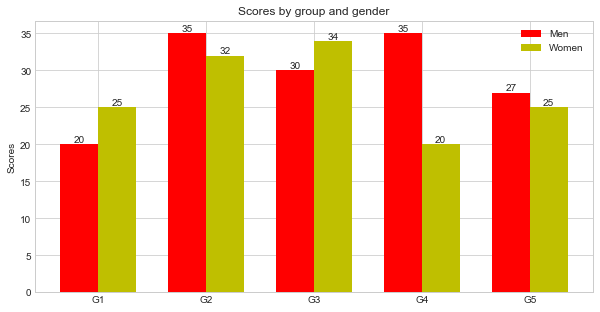

In [532]:
"""
========
Barchart
========

A bar plot with errorbars and height labels on individual bars
"""

# plotting graph for pso

# figure(figsize=(1,1))
N = 5
# men_means = (20, 35, 30, 35, 27)
iteration_5 = [0.9389,0.8543,0.8992,0.8367]
iteration_10 = [0.8269,0.8954,0.8956,0.8923]
iteration_40 = [0.8881,0.9069,0.9112,0.9206]

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(10, 5, forward=True)
rects1 = ax.bar(ind, men_means, width, color='r')

women_means = (25, 32, 34, 20, 25)
rects2 = ax.bar(ind + width, women_means, width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))

ax.legend((rects1[0], rects2[0]), ('Men', 'Women'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

index= [0 3 6 9]


C:\Users\Garvit\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


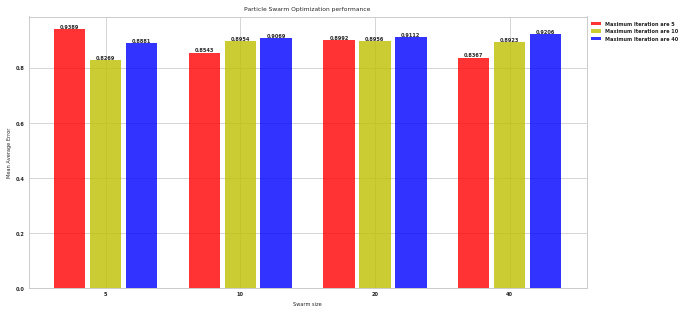

In [610]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
 
# data to plot
n_groups = 4
iteration_5 = (0.9389,0.8543,0.8992,0.8367)
iteration_10 = (0.8269,0.8954,0.8956,0.8923)
iteration_40 = (0.8881,0.9069,0.9112,0.9206)
 
# create plot
fig, ax = plt.subplots(figsize=(10, 5))
index = np.arange(0,12,3)
print("index=",index)
bar_width = 0.7
opacity = 0.8
 
rects1 = plt.bar(index, iteration_5, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Maximum Iteration are 5')
 
rects2 = plt.bar(index + bar_width+0.1, iteration_10, bar_width,
                 alpha=opacity,
                 color='y',
                 label='Maximum Iteration are 10')

rects3 = plt.bar(index + bar_width + bar_width+0.2, iteration_40, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Maximum Iteration are 40')

plt.xlabel('Swarm size')
plt.ylabel('Mean Average Error')
plt.title('Particle Swarm Optimization performance')
plt.xticks(index + bar_width + 0.1, ('5', '10', '20', '40'))
plt.legend( bbox_to_anchor=(1.0,1.0))
 
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                '%.4f' % height,
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
plt.show()